# Imports, config and logging server

In [1]:
from sympy.physics.units import energy
%matplotlib inline

# Standard library
import ast
from copy import deepcopy
from concurrent.futures import ThreadPoolExecutor
from uuid import uuid4

# Third-party libraries
import optuna
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.model_selection import KFold

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Subset

import mlflow
from mlflow.pytorch import load_model

import torchmetrics.functional.regression as R

# Project-specific imports
from default import *
from config import DIRECTORY, PORT
from tools import MLFlowSession
from models.architecture import MLP
from models.processing import StandardScaler
from dataset import DummyTrussDataset
from losses import StiffnessToLoadLoss, EnergyLoss, NodeEquilibriumLoss

# Set random state and device
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

device = torch.device(
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)

# Set working directory and figure directory
%cd -q {PROJECT_HOME}
figure_dir = os.path.join(os.getcwd(), '022025_experiment/figures')

# Configure MLFlow server
DIRECTORY = DIRECTORY['005']
PORT = PORT['005']
server = MLFlowSession(PORT=PORT, DIRECTORY=DIRECTORY)
server.start()

# Set dataset dirs
n_input_dims = 11
n_output_dims = 5

loss = 'hybrid'

train_dataset_dir = r"data/dataset/dummy_truss"
test_dataset_dir = r"data/dataset/dummy_truss"

_validation_ds = DummyTrussDataset(f"{test_dataset_dir}/val_512.hdf5")

MLflow server started at http://127.0.0.1:6005
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/005/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/005
Workers: 4
Process group: 60269


# Training procedure

In [2]:
def compute_stiffness_matrix(EA):
    EA0 = EA[:, 0]
    EA1 = EA[:, 1]
    EA2 = EA[:, 2]
    EA3 = EA[:, 3]
    EA4 = EA[:, 4]
    batch_size = len(EA)
    K = torch.zeros(batch_size, 8, 8, dtype=EA.dtype, device=EA.device)
    K[:, 0, 0] = 1.
    K[:, 1, 1] = 1.
    K[:, 5, 5] = 1.
    K[:, 2, 2] = 0.2 * EA0 + 0.2 * EA1
    K[:, 2, 4] = -0.2 * EA1
    K[:, 3, 3] = 0.2 * EA4
    K[:, 3, 7] = -0.2 * EA4
    K[:, 4, 2] = -0.2 * EA1
    K[:, 4, 4] = 0.2 * EA1 + 0.0707106781186547 * EA2
    K[:, 4, 6] = -0.0707106781186547 * EA2
    K[:, 4, 7] = 0.0707106781186547 * EA2
    K[:, 6, 4] = -0.0707106781186547 * EA2
    K[:, 6, 6] = 0.0707106781186547 * EA2 + 0.0707106781186547 * EA3
    K[:, 6, 7] = -0.0707106781186547 * EA2 + 0.0707106781186547 * EA3
    K[:, 7, 3] = -0.2 * EA4
    K[:, 7, 4] = 0.0707106781186547 * EA2
    K[:, 7, 6] = -0.0707106781186547 * EA2 + 0.0707106781186547 * EA3
    K[:, 7, 7] = 0.0707106781186547 * EA2 + 0.0707106781186547 * EA3 + 0.2 * EA4

    return K


def q_from_x_w(x, w):
    batch_size = len(x)
    q = w.reshape((batch_size, -1)).clone()
    q[:, 3] = x[:, 5]

    return q.unsqueeze(-1)


def u_from_x(x):
    batch_size = len(x)
    u = torch.zeros((batch_size, 8), device=x.device)
    u[:, [2, 3, 4]] = x[:, :3]
    u[:, [6, 7]] = x[:, [3, 4]]

    return u.unsqueeze(-1)


def compute_oriented_incidence_matrix(ds, n=0, device=device):
    n_nodes: int = 4
    n_elements: int = 5
    m = torch.zeros((n_nodes, n_elements, 2))
    coordinates = torch.tensor(ds.nodes_coordinate[n].reshape((n_nodes, 2)))
    for ele_idx, (n1_idx, n2_idx) in enumerate(ds.connectivity_matrix[n]):
        n1 = coordinates[n1_idx]
        n2 = coordinates[n2_idx]

        v1 = n1 - n2
        v2 = n2 - n1

        m[n1_idx, ele_idx] = v1 / v1.norm()
        m[n2_idx, ele_idx] = v2 / v2.norm()

    return [{j: v.to(device) for j, v in enumerate(n_incidence) if not torch.all(v == 0.)} for n_incidence in m]


def compute_base_factor(model, dl, input_scaler, target_scaler, criterion):
    model.eval()
    with torch.no_grad():
        loss_base_scale = {'mse': 0., 'stiffness': 0., 'equilibrium': 0., 'energy': 0.}
        for input, target, u_, q_, w, r in dl:
            input, target = input.to(device), target.to(device)
            w, r = w.to(device), r.to(device)

            u = u_from_x(input)
            q = q_from_x_w(input, w)
            e = input[:, -5:]

            r.requires_grad_(True)

            z_input = input_scaler.transform(input)
            z_target = target_scaler.transform(target)

            z_target_pred = model(z_input)
            target_pred = target_scaler.inverse_transform(z_target_pred)

            k_pred = compute_stiffness_matrix(target_pred)

            loss_mse = criterion['mse'](z_target_pred, z_target)
            loss_stiffness = criterion['stiffness'](k_pred * 1e-6, u_from_x(input) * 1e3, q_from_x_w(input, w) * 1e-3)
            loss_energy = criterion['energy'](target_pred, e, u.reshape((-1, 4, 2)), q.reshape((-1, 4, 2)), L)
            loss_equilibrium = criterion['equilibrium'](target_pred, e, q, r, m_incidence)

            loss_base_scale['mse'] += loss_mse / len(dl)
            loss_base_scale['equilibrium'] += loss_equilibrium / len(dl)
            loss_base_scale['energy'] += loss_energy / len(dl)
            loss_base_scale['stiffness'] += loss_stiffness / len(dl)

    return loss_base_scale


m_incidence = compute_oriented_incidence_matrix(_validation_ds)
L = torch.tensor(_validation_ds.bars_length_init[0]).to(device, dtype=torch.float32)

In [3]:
def train_step(model, batch, input_scaler, target_scaler, optimizer, criterion, factor, base_factor):
    model.train()

    input, target, u, q, w, r = batch
    input, target = input.to(device), target.to(device)
    w, r = w.to(device), r.to(device)

    u = u_from_x(input)
    q = q_from_x_w(input, w)
    e = input[:, -5:]

    r.requires_grad_(True)

    z_input = input_scaler.transform(input)
    z_target = target_scaler.transform(target)

    z_target_pred = model(z_input)
    target_pred = target_scaler.inverse_transform(z_target_pred)

    k_pred = compute_stiffness_matrix(target_pred)

    optimizer.zero_grad()

    loss_mse = criterion['mse'](z_target_pred, z_target)
    loss_stiffness = criterion['stiffness'](k_pred * 1e-6,
                                            u_from_x(input) * 1e3,
                                            q_from_x_w(input, w) * 1e-3)
    loss_energy = criterion['energy'](target_pred, e, u.reshape((-1, 4, 2)), q.reshape((-1, 4, 2)), L)
    loss_equilibrium = criterion['equilibrium'](target_pred, e, q, r, m_incidence)

    loss = (loss_mse * factor['mse'] / base_factor['mse'] +
            loss_stiffness * factor['stiffness'] / base_factor['stiffness'] +
            loss_energy * factor['energy'] / base_factor['energy'] +
            loss_equilibrium * factor['equilibrium'] / base_factor['equilibrium'])

    loss.backward()
    optimizer.step()

    metrics = compute_metrics(model, target_pred, z_target_pred, target, z_target)
    metrics['loss'] = loss.item()
    metrics['loss_mse'] = loss_mse.item()
    metrics['loss_stiffness'] = loss_stiffness.item()
    metrics['loss_energy'] = loss_energy.item()
    metrics['loss_equilibrium'] = loss_equilibrium.item()

    return metrics


def validation(model, batch, input_scaler, target_scaler, criterion, factor, base_factor):
    model.eval()
    with torch.no_grad():
        input, target, u, q, w, r = batch
        input, target = input.to(device), target.to(device)
        w, r = w.to(device), r.to(device)

        u = u_from_x(input)
        q = q_from_x_w(input, w)
        e = input[:, -5:]

        r.requires_grad_(True)

        z_input = input_scaler.transform(input)
        z_target = target_scaler.transform(target)

        z_target_pred = model(z_input)
        target_pred = target_scaler.inverse_transform(z_target_pred)

        k_pred = compute_stiffness_matrix(target_pred)

        loss_mse = criterion['mse'](z_target_pred, z_target)
        loss_stiffness = criterion['stiffness'](k_pred * 1e-6,
                                                u_from_x(input) * 1e3,
                                                q_from_x_w(input, w) * 1e-3)
        loss_energy = criterion['energy'](target_pred, e, u.reshape((-1, 4, 2)), q.reshape((-1, 4, 2)), L)
        loss_equilibrium = criterion['equilibrium'](target_pred, e, q, r, m_incidence)

        loss = (loss_mse * factor['mse'] / base_factor['mse'] +
                loss_stiffness * factor['stiffness'] / base_factor['stiffness'] +
                loss_energy * factor['energy'] / base_factor['energy'] +
                loss_equilibrium * factor['equilibrium'] / base_factor['equilibrium'])

    metrics = compute_metrics(model, target_pred, z_target_pred, target, z_target)
    metrics['loss'] = loss.item()
    metrics['loss_mse'] = loss_mse.item()
    metrics['loss_stiffness'] = loss_stiffness.item()
    metrics['loss_energy'] = loss_energy.item()
    metrics['loss_equilibrium'] = loss_equilibrium.item()

    return metrics


def compute_metrics(model, target_pred, z_target_pred, target, z_target):
    model.eval()

    with torch.no_grad():
        r2 = R.r2_score(z_target_pred, z_target)
        if r2.isinf():  # Switch to 64 bits in case of overflow
            r2 = R.r2_score(target_pred.cpu().to(torch.float64), target.cpu().to(torch.float64))
        mape = R.mean_absolute_percentage_error(target_pred, target)
        rmse = R.mean_squared_error(target_pred * 1e-6, target * 1e-6, squared=False)
        if rmse.isinf():  # Switch to 64 bits in case of overflow
            rmse = R.mean_squared_error(target_pred.cpu().to(torch.float64), target.cpu().to(torch.float64),
                                        squared=False)

    return {'r2': r2, 'mape': mape, 'rmse_MN': rmse}


def log_epoch(train_metrics, val_metrics, epoch):
    metrics = dict()
    metrics.update({f'train_{k}': v for k, v in train_metrics.items()})
    metrics.update({f'val_{k}': v for k, v in val_metrics.items()})

    mlflow.log_metrics(metrics, step=epoch + 1)


def log_model(name, model, signature, metadata=None):
    mlflow.pytorch.log_model(
        pytorch_model=model,
        artifact_path=name,
        signature=signature,
        metadata=metadata
    )


def console_log(epoch, train_metrics, val_metrics):
    print(f">> Epoch {epoch + 1:4d}", end='  ')
    print(f"TRAIN", end='   ')
    metric_names = {k for k in train_metrics.keys() if k != 'loss'}
    metric_names = ['loss'] + sorted(metric_names)
    for k in metric_names:
        v = train_metrics[k]
        print(f"{k}: {v: 1.4f}", end='   ')

    print("  ||  ", end='')
    print(f"VALIDATION", end='   ')
    metric_names = {k for k in val_metrics.keys() if k != 'loss'}
    metric_names = ['loss'] + sorted(metric_names)
    for k in metric_names:
        v = val_metrics[k]
        print(f"{k}: {v: 1.4f}", end='   ')
    print()


def train(model, train_dataset, val_dataset, train_batch_size, val_batch_size, n_epoch, optimizer, criterion, factor,
          log_step=10):
    model = model.to(device)
    train_dl = DataLoader(train_dataset, train_batch_size, shuffle=True)
    val_dl = DataLoader(val_dataset, val_batch_size, shuffle=False)

    input_scaler = StandardScaler(train_dataset[0][0].__len__()).to(device)
    target_scaler = StandardScaler(train_dataset[0][1].__len__()).to(device)

    # Train the scaler
    input, target = None, None
    for batch in train_dl:
        input, target, u, q, w, r = batch
        input, target = input.to(device), target.to(device)
        input_scaler.partial_fit(input)
        target_scaler.partial_fit(target)

    signature = mlflow.models.infer_signature(input.cpu().detach().numpy(),
                                              input_scaler.transform(input).cpu().detach().numpy())
    log_model('input_scaler', input_scaler, signature=signature)

    signature = mlflow.models.infer_signature(target.cpu().detach().numpy(),
                                              target_scaler.transform(target).cpu().detach().numpy())
    log_model('target_scaler', target_scaler, signature=signature)

    best_val_metric = {
        'mape': {model: None, 'value': np.inf, 'epoch': -1},
        'rmse_MN': {model: None, 'value': np.inf, 'epoch': -1},
        'loss': {model: None, 'value': np.inf, 'epoch': -1},
        'r2': {model: None, 'value': -np.inf, 'epoch': -1}
    }

    base_factor = compute_base_factor(model, train_dl, input_scaler, target_scaler, criterion)

    for epoch in range(n_epoch):
        train_metrics = {}
        val_metrics = {}
        for batch in train_dl:
            train_metrics_epoch = train_step(model, batch, input_scaler, target_scaler, optimizer, criterion,
                                             factor=factor, base_factor=base_factor)
            for k, m in train_metrics_epoch.items():
                if k not in train_metrics: train_metrics[k] = []
                train_metrics[k].append(m)

        for batch in val_dl:
            val_metrics_epoch = validation(model, batch, input_scaler, target_scaler, criterion,
                                           factor=factor, base_factor=base_factor)
            for k, m in val_metrics_epoch.items():
                if k not in val_metrics: val_metrics[k] = []
                val_metrics[k].append(m)

        # Compute the mean on GPU  -> Faster for batch
        train_metrics = {name: torch.tensor(metrics, device=device, dtype=torch.float32).mean() for name, metrics in
                         train_metrics.items()}
        val_metrics = {name: torch.tensor(metrics, device=device, dtype=torch.float32).mean() for name, metrics in
                       val_metrics.items()}

        log_epoch(train_metrics, val_metrics, epoch)

        negative_metrics = {'r2'}  # Set of metrics which are better when higher

        for k, v in val_metrics.items():
            if k not in best_val_metric: continue
            f = 1 if k not in negative_metrics else -1
            if f * best_val_metric[k]['value'] >= f * v:
                best_val_metric[k] = {'model': deepcopy(model), 'value': v.item(), 'epoch': epoch + 1}

        if (log_step < 0): continue
        if (epoch % log_step == 0):
            console_log(epoch, train_metrics, val_metrics)

    input, target, u, q, w, r = train_dl.__iter__().__next__()
    signature = mlflow.models.infer_signature(input.cpu().detach().numpy(), target.cpu().detach().numpy())
    for k, v in best_val_metric.items():
        metric = v['value']
        epoch = v['epoch']
        log_model(f"{k}_model", v['model'], signature=signature, metadata={'metric': metric, 'epoch': epoch + 1})

    return best_val_metric


def trial_routine(run_name, train_routine, mlp_params, train_dataset, val_dataset, train_batch_size,
                  val_batch_size, n_epoch, optimizer, lr, criterion, fold, factor,
                  log_step=10, log_params=None):
    with mlflow.start_run(run_name=run_name):
        # Model initialization
        model = MLP(**mlp_params)

        # Model information logging
        capacity = sum(np.prod(p.size()) for p in filter(lambda p: p.requires_grad, model.parameters()))
        if log_params is not None:
            mlflow.log_params(log_params)
        mlflow.log_params(mlp_params)
        mlflow.log_params({
            'n_hidden_layers': len(mlp_params['hidden_dims']),
            'hidden_layers_size': mlp_params['hidden_dims'][0],
            'capacity': capacity,
            'n_epoch': n_epoch,
            'val_batch_size': val_batch_size,
            'train_batch_size': train_batch_size,
            'train_size': train_dataset.__len__(),
            'val_size': val_dataset.__len__(),
            'k-fold': fold,
            'optimizer': optimizer.__name__,
            'learning_rate': f"{lr:.1e}",
            'criterion': 'hybrid',
        })

        # Run the training with the configuration
        return train_routine(model, train_dataset, val_dataset,
                             train_batch_size, val_batch_size,
                             n_epoch, optimizer(model.parameters(), lr=lr),
                             {k: v().to(device) for k, v in criterion.items()},
                             log_step=log_step, factor=factor)

In [4]:
def plot(results, configs, metrics, titles, axis_labels, labels, logs=None, xlim=None, ylim=None, legend_title=None,
         figsize=(5.8, 20), legend_ncols=5, legend_blank=True, train=True, val=True):
    if not isinstance(metrics, list):
        metrics = [metrics]
    if logs is None:
        logs = [True] * len(metrics)
    elif not isinstance(logs, list):
        logs = [logs] * len(metrics)

    cmap = mpl.colormaps['tab10']
    c = cmap(np.linspace(0, 1, len(configs)))

    if len(metrics) == 1:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
        axs = [ax]
    else:
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)
        axs = [ax for row in axs for ax in row]

    for i, (title, y_axis_label,  metric, log) in enumerate(zip(titles, axis_labels, metrics, logs)):
        ax = axs[i]
        # Plot the data but collect the handles for the legend
        config_handles = []
        for i, conf in enumerate(configs):
            # Store only the validation line handles for the legend
            l = len(results[conf][f'train_{metric}'])
            if train:
                h = ax.plot(np.arange(l), results[conf][f'train_{metric}'], alpha=.75, ls='--', lw=1, c=c[i])[0]
            if val:
                h2 = ax.plot(np.arange(l), results[conf][f'val_{metric}'], ls='-', lw=1, c=c[i])[0]
                config_handles.append(h2)
            elif train:
                config_handles.append(h)

        # Create custom handles for the line style legend
        line_style_handles = []
        if train:
            line_style_handles += [
                Line2D([0], [0], color='black', lw=1, ls='--', dashes=(5, 5), alpha=0.5, label='Training')
            ]
        if val:
            line_style_handles += [
                Line2D([0], [0], color='black', lw=1, ls='-', label='Validation'),
            ]
        if legend_blank:
            line_style_handles += [
                Line2D([0], [0], color='black', alpha=0, lw=1, ls='-')
            ]

        # Get the current position and size of the axis
        box = ax.get_position()
        # Reduce the width of the axis to make room for the legend
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Combine both sets of handles and labels
        all_handles = line_style_handles + config_handles
        all_labels = []
        if train:
            all_labels += ['Training']
        if val:
            all_labels += ['Validation']
        if legend_blank:
            all_labels += ['']
        all_labels += labels

        # Create a single legend with both line styles and configurations
        plt.figlegend(all_handles, all_labels, loc='upper center', ncols=legend_ncols,
                      bbox_to_anchor=(.5, 0), fontsize=10,
                      title="Legend" if legend_title is None else legend_title)

        ax.set_title(title, fontsize=12)
        if log:
            ax.set_yscale('log')
        ax.set_ylabel(f"{y_axis_label}", fontsize=10)
        ax.set_xlabel("epoch [/]", fontsize=10)

        if xlim: ax.set_xlim(*xlim)
        if ylim: ax.set_ylim(*ylim)

    fig.tight_layout(w_pad=4)
    # Adjust right padding to make room for the legend
    return fig, axs

# Hyper-parameter tuning

In [5]:
TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512
kfold = 5

N_EPOCH = 200
LR = 1e-3

log_step = -1

ds = DummyTrussDataset(f"{train_dataset_dir}/4096.hdf5")
mlflow.set_tracking_uri(uri=server.url())

# Parameters

## Factor

In [6]:
%%capture
mlflow.set_experiment("factors")


def objective(trial):
    # === 1. Suggest loss weights ===
    loss_factors = {
        'mse': 1.0,  #trial.suggest_float('lambda_mse', 1e-3, 10.0, log=True),
        'energy': trial.suggest_float('lambda_energy', 1e-6, 10.0, log=True),
        'stiffness': trial.suggest_float('lambda_stiffness', 1e-6, 10.0, log=True),
        'equilibrium': trial.suggest_float('lambda_equilibrium', 1e-6, 10.0, log=True)
    }
    experiment_id = uuid4()
    results_folds = []
    for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
        train_dataset, val_dataset = Subset(ds, train_idx), Subset(ds, val_idx)

        params_to_log = {'loss': loss,
                         'uuid': experiment_id}
        params_to_log.update({f"factor_{k}": v for k, v in loss_factors.items()})

        results = trial_routine(None, train,
                                {
                                    'input_dim': n_input_dims,
                                    'hidden_dims': [40] * 4,
                                    'output_dim': n_output_dims,
                                    'activation': "tanh",
                                    'activation_params': None,
                                    'dropout': 0.0,
                                    'batch_norm': False,
                                    'layer_norm': False,
                                    'normalization_params': None,
                                    'output_activation': None,
                                    'output_activation_params': None,
                                },
                                train_dataset,
                                val_dataset,
                                TRAIN_BATCH_SIZE,
                                VAL_BATCH_SIZE,
                                100,
                                torch.optim.Adam,
                                LR,
                                {'mse': nn.MSELoss,
                                 'energy': EnergyLoss,
                                 'stiffness': StiffnessToLoadLoss,
                                 'equilibrium': NodeEquilibriumLoss},
                                kfold,
                                loss_factors,
                                log_step,
                                params_to_log
                                )
        results_folds.append(results)
    average_mape = np.mean([r['mape']['value'] for r in results_folds])
    return average_mape


# === 3. Run Optuna ===
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, n_jobs=5)

[I 2025-07-27 17:29:32,024] A new study created in memory with name: no-name-903903b2-6942-446d-a607-cf60ab3d2632
[I 2025-07-27 17:34:47,707] Trial 4 finished with value: 0.23801735937595367 and parameters: {'lambda_energy': 0.03442164952919635, 'lambda_stiffness': 6.2044649423013935e-06, 'lambda_equilibrium': 3.681342351957452}. Best is trial 4 with value: 0.23801735937595367.
[I 2025-07-27 17:34:58,548] Trial 0 finished with value: 0.13853443264961243 and parameters: {'lambda_energy': 0.0008232316311246118, 'lambda_stiffness': 2.4363440582044857e-05, 'lambda_equilibrium': 0.0005285094488330211}. Best is trial 0 with value: 0.13853443264961243.
[I 2025-07-27 17:37:10,115] Trial 2 finished with value: 0.1374969720840454 and parameters: {'lambda_energy': 0.0007144809857283542, 'lambda_stiffness': 0.22497868947627908, 'lambda_equilibrium': 0.0014267391239867811}. Best is trial 2 with value: 0.1374969720840454.
[I 2025-07-27 17:40:00,863] Trial 5 finished with value: 0.19396140277385712 a

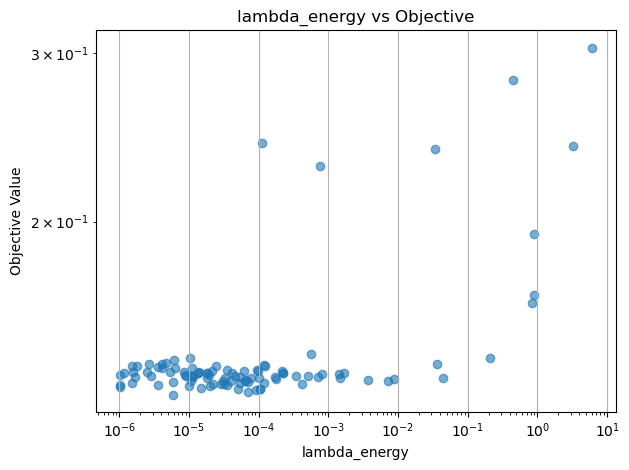

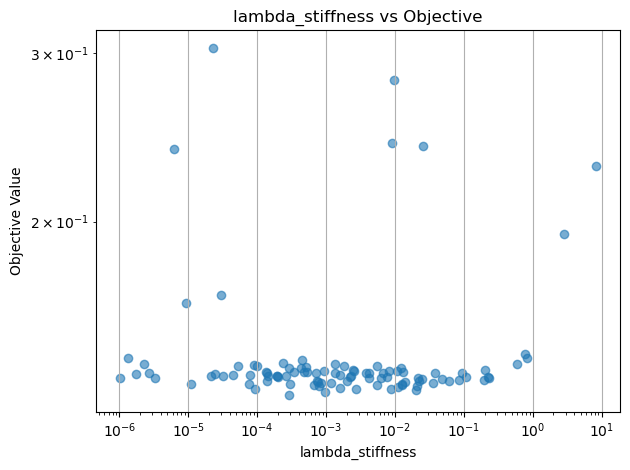

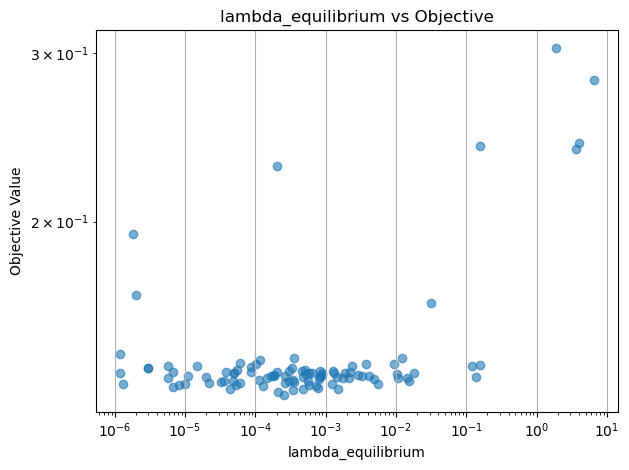

In [26]:
import matplotlib.pyplot as plt

params = study.best_trial.params.keys()

for param in params:
    x = []
    y = []
    for trial in study.trials:
        if trial.state.name == 'COMPLETE' and param in trial.params:
            x.append(trial.params[param])
            y.append(trial.value)

    plt.figure()
    plt.scatter(x, y, alpha=0.6)
    plt.xlabel(param)
    plt.ylabel("Objective Value")
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f"{param} vs Objective")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [27]:
# Get top 10 trials
top_10 = study.trials_dataframe().sort_values("value", ascending=True).head(10)

# Print parameters and their corresponding objective values
for i, row in top_10.iterrows():
    print(
        f"Trial #{row['number']}, Value: {row['value']:.4e}, Params - energy: {row['params_lambda_energy']:.3e} equilibrium: {row['params_lambda_equilibrium']:.3e} stiffness: {row['params_lambda_stiffness']:.3e}")

Trial #20, Value: 1.3179e-01, Params - energy: 5.905e-06 equilibrium: 2.549e-04 stiffness: 2.902e-04
Trial #75, Value: 1.3256e-01, Params - energy: 6.989e-05 equilibrium: 2.066e-04 stiffness: 9.663e-04
Trial #76, Value: 1.3339e-01, Params - energy: 9.130e-05 equilibrium: 3.391e-04 stiffness: 2.010e-02
Trial #23, Value: 1.3361e-01, Params - energy: 5.046e-05 equilibrium: 1.494e-03 stiffness: 9.274e-05
Trial #99, Value: 1.3362e-01, Params - energy: 1.038e-04 equilibrium: 4.744e-04 stiffness: 2.694e-03
Trial #93, Value: 1.3373e-01, Params - energy: 1.061e-04 equilibrium: 4.415e-05 stiffness: 8.784e-03
Trial #66, Value: 1.3376e-01, Params - energy: 1.466e-05 equilibrium: 7.795e-04 stiffness: 1.576e-03
Trial #26, Value: 1.3438e-01, Params - energy: 1.016e-06 equilibrium: 6.668e-06 stiffness: 1.125e-02
Trial #62, Value: 1.3455e-01, Params - energy: 2.003e-05 equilibrium: 7.356e-04 stiffness: 2.069e-02
Trial #15, Value: 1.3459e-01, Params - energy: 1.006e-05 equilibrium: 1.289e-04 stiffness: 

In [34]:
best_factors = study.best_trial.params
best_factors['mse'] = 1.

best_factors = {k.split('_')[-1]: v for k, v in best_factors.items()}

print(best_factors)

{'energy': 5.904664402005973e-06, 'stiffness': 0.00029018810624586555, 'equilibrium': 0.0002549088097418874, 'mse': 1.0}


## Model capacity

In [35]:
%%capture
mlflow.set_experiment("capacity")

n_layers_values = [2, 3, 4, 5]
n_neurons_values = [15, 20, 30, 40]
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for n_layers in n_layers_values:
        for n_neurons in n_neurons_values:
            for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
                hidden_dims = [n_neurons for _ in range(n_layers)]
                train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
                future = executor.submit(trial_routine, None, train,
                                         {
                                             'input_dim': n_input_dims,
                                             'hidden_dims': hidden_dims,
                                             'output_dim': n_output_dims,
                                             'activation': "tanh",
                                             'activation_params': None,
                                             'dropout': 0.0,
                                             'batch_norm': False,
                                             'layer_norm': False,
                                             'normalization_params': None,
                                             'output_activation': None,
                                             'output_activation_params': None,
                                         },
                                         train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                         N_EPOCH,
                                         torch.optim.Adam, LR, {'mse': nn.MSELoss,
                                                                'energy': EnergyLoss,
                                                                'stiffness': StiffnessToLoadLoss,
                                                                'equilibrium': NodeEquilibriumLoss},
                                         kfold, best_factors, log_step,
                                         {'loss': loss})
                futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

In [7]:
experiment = mlflow.get_experiment_by_name("capacity")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

layers_combinations = set()
for n_layers in runs_df['params.n_hidden_layers'].unique():
    for layer_size in runs_df['params.hidden_layers_size'].unique():
        layers_combinations.add((n_layers, layer_size))

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in layers_combinations}
for n, size in layers_combinations:
    run_ids = runs_df[
        (runs_df['params.loss'] == loss) &
        (runs_df['params.n_hidden_layers'] == n) &
        (runs_df['params.hidden_layers_size'] == size)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[(n, size)][metric_name].append(
                [metric.value for metric in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

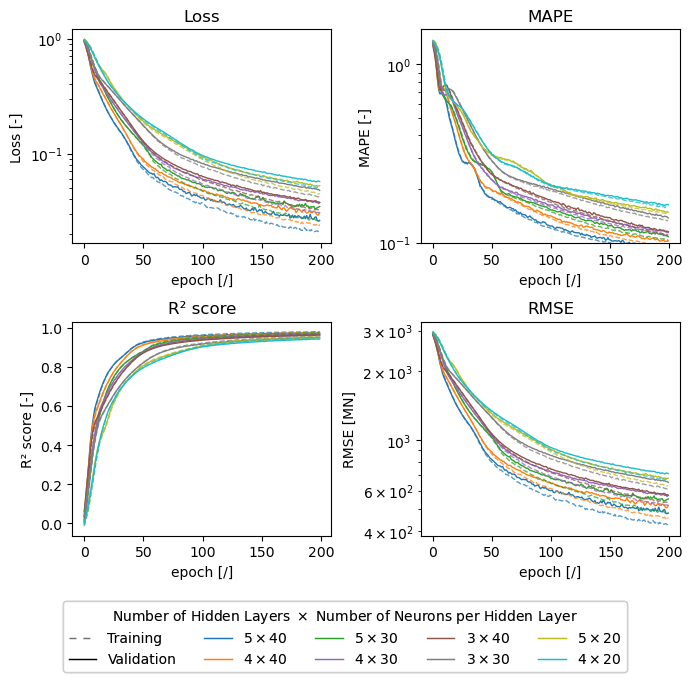

In [10]:
# Your existing code for preparing the data
configs_by_val_mape = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = configs_by_val_mape[:8]

configs = sorted(configs)
configs = [x[1] for x in configs]

labels = [fr"${cfg[0]} \times {cfg[1]}$" for cfg in configs]

fig, axs = plot(results, configs, ['loss', 'mape', 'r2', 'rmse_MN'], ['Loss', 'MAPE', 'R² score', 'RMSE'],
                ['Loss [-]', 'MAPE [-]', 'R² score [-]', 'RMSE [MN]'],
                labels, logs=[True, True, False, True], figsize=(7, 6), legend_blank=False,
                legend_title=r'$\text{Number of Hidden Layers }\times\text{ Number of Neurons per Hidden Layer}$')

for ax in axs[1:2]:
    ax.set_ylim([.099, ax.get_ylim()[1]])

plt.savefig("figures/img/03-mlp_hybrid_capacity_tuning.pdf", transparent=True, bbox_inches='tight')
plt.show()
plt.close()

In [8]:
# Pareto front technique
best_mape = configs_by_val_mape[0][0]
candidates = [x[1] for x in filter(lambda x: x[0] <= best_mape * 1.02, configs_by_val_mape)]

filtered_results = {k: results[k] for k in candidates}

configs_by_val_rmse = sorted([(np.min(v['val_rmse_MN']), k) for k, v in filtered_results.items()])
best_candidate = [int(x) for x in configs_by_val_rmse[0][1]]
best_hidden_dims = [best_candidate[1]] * best_candidate[0]

print(f"Best candidate is: {best_candidate} according to the pareto front.")

Best candidate is: [5, 40] according to the pareto front.


In [39]:
to_delete = [
    'n_layers_values', 'n_neurons_values', 'executor', 'futures', 'n_layers', 'n_neurons',
    'fold', 'train_idx', 'val_idx', 'hidden_dims', 'train_dataset', 'validation_dataset',
    'future', 'experiment', 'runs_df', 'cols', 'metrics_names', 'layers_combinations',
    'client', 'results', 'n', 'size', 'run_ids', 'run_id', 'metric_name', 'k',
    'configs_by_val_mape', 'configs', 'labels', 'best_mape', 'candidates',
    'filtered_results', 'configs_by_val_rmse', 'best_candidate'
]

for var in to_delete:
    try:
        globals().pop(var, None)
    except KeyError:
        continue


## Activation function

In [40]:
%%capture
mlflow.set_experiment("activation_function")

activation_values = ['relu', 'gelu', 'tanh', 'sigmoid',
                     'leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']
activation_params_values = [None, None, None, None,
                            {'negative_slope': 5e-1}, {'negative_slope': 1e-1}, {'negative_slope': 5e-2},
                            {'negative_slope': 1e-2}]

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for activation, activation_params in zip(activation_values, activation_params_values):
        for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
            train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
            future = executor.submit(trial_routine, None, train,
                                     {
                                         'input_dim': n_input_dims,
                                         'hidden_dims': best_hidden_dims,
                                         'output_dim': n_output_dims,
                                         'activation': activation,
                                         'activation_params': activation_params,
                                         'dropout': 0.0,
                                         'batch_norm': False,
                                         'layer_norm': False,
                                         'normalization_params': None,
                                         'output_activation': None,
                                         'output_activation_params': None,
                                     },
                                     train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                     N_EPOCH,
                                     torch.optim.Adam, LR, {'mse': nn.MSELoss,
                                                            'energy': EnergyLoss,
                                                            'stiffness': StiffnessToLoadLoss,
                                                            'equilibrium': NodeEquilibriumLoss},
                                     kfold, best_factors, log_step,
                                     {'loss': loss})
            futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

In [20]:
experiment = mlflow.get_experiment_by_name("activation_function")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

activations_combinations = set()
for m in runs_df['params.activation'].unique():
    for n in runs_df[runs_df['params.activation'] == m]['params.activation_params'].unique():
        activations_combinations.add((m, n))

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in activations_combinations}
for k in activations_combinations:
    (act, params) = k
    run_ids = runs_df[
        (runs_df['params.loss'] == loss) &
        (runs_df['params.activation'] == act) &
        (runs_df['params.activation_params'] == params)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[k][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

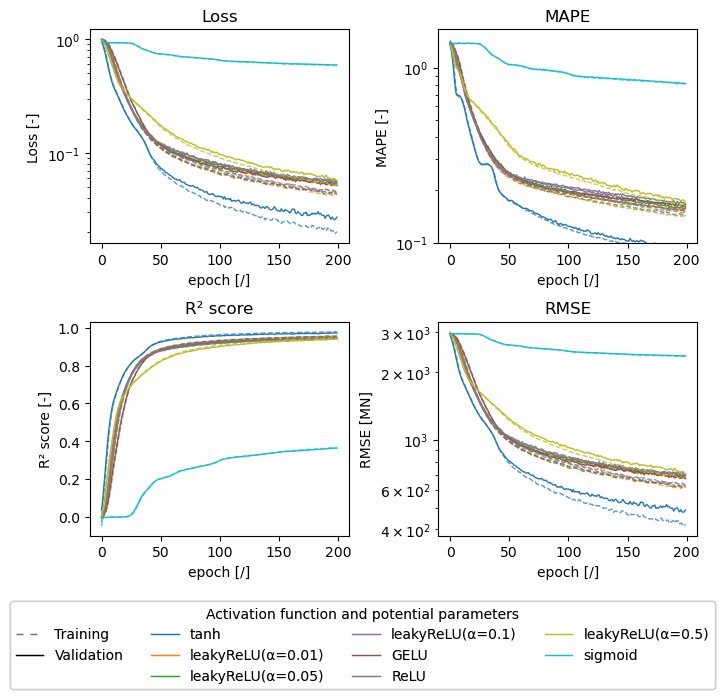

In [21]:
configs_by_val_mape = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])

configs = [x[1] for x in configs_by_val_mape]

labels = [f"[{cfg[0]}]" if cfg[1] == 'None' else f"[{cfg[0]}, {cfg[1]}]" for cfg in configs]
labels = [
    (label[1:-1]
     .replace('relu', 'ReLU')
     .replace('gelu', 'GELU')
     .replace(', ', '')
     .replace('{', '(')
     .replace('}', ')')
     .replace("'negative_slope': ", '⍺=')
     .replace('_', ''))
    for label in labels
]

fig, axs = plot(results, configs, ['loss', 'mape', 'r2', 'rmse_MN'], ['Loss', 'MAPE', 'R² score', 'RMSE'],
                ['Loss [-]', 'MAPE [-]', 'R² score [-]', 'RMSE [MN]'],
                labels, logs=[True, True, False, True], figsize=(7, 6), legend_blank=True, legend_ncols=4,
                legend_title=r'Activation function and potential parameters')

for ax in axs[1:2]:
    ax.set_ylim([.099, ax.get_ylim()[1]])

plt.savefig("figures/img/03-mlp_hybrid_activation_tuning.pdf", transparent=True, bbox_inches='tight')
plt.show()
plt.close()

In [11]:
# Pareto front technique
best_mape = configs_by_val_mape[0][0]
candidates = [x[1] for x in filter(lambda x: x[0] <= best_mape * 1.02, configs_by_val_mape)]

filtered_results = {k: results[k] for k in candidates}

configs_by_val_rmse = sorted([(np.min(v['val_rmse_MN']), k) for k, v in filtered_results.items()])

best_candidate = configs_by_val_rmse[0][1]
best_activation = best_candidate[0]
best_activation_params = ast.literal_eval(best_candidate[1])

print(f"Best candidate is: {best_candidate} according to the pareto front.")

Best candidate is: ('tanh', 'None') according to the pareto front.


In [44]:
to_delete = [
    'activation_values', 'activation_params_values', 'executor', 'futures',
    'activation', 'activation_params', 'fold', 'train_idx', 'val_idx',
    'train_dataset', 'validation_dataset', 'future', 'experiment', 'runs_df',
    'cols', 'metrics_names', 'activations_combinations', 'client', 'results',
    'k', 'act', 'params', 'run_ids', 'run_id', 'metric_name', 'configs_by_val_mape',
    'configs', 'labels', 'best_mape', 'candidates', 'filtered_results',
    'configs_by_val_rmse', 'best_candidate'
]

for var in to_delete:
    try:
        del globals()[var]
    except KeyError:
        pass

## Learning rate

In [47]:
%%capture
mlflow.set_experiment("learning_rate")

lr_values = sorted(np.hstack([f * np.logspace(-4, -3, 2) for f in [1, 2.5, 5, 7.5]]))
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for LR in lr_values:
        for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
            train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
            future = executor.submit(trial_routine, None, train,
                                     {
                                         'input_dim': n_input_dims,
                                         'hidden_dims': best_hidden_dims,
                                         'output_dim': n_output_dims,
                                         'activation': best_activation,
                                         'activation_params': best_activation_params,
                                         'dropout': 0.0,
                                         'batch_norm': False,
                                         'layer_norm': False,
                                         'normalization_params': None,
                                         'output_activation': None,
                                         'output_activation_params': None,
                                     },
                                     train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                     N_EPOCH,
                                     torch.optim.Adam, LR, {'mse': nn.MSELoss,
                                                            'energy': EnergyLoss,
                                                            'stiffness': StiffnessToLoadLoss,
                                                            'equilibrium': NodeEquilibriumLoss},
                                     kfold, best_factors, log_step,
                                     {'loss': loss})
            futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

In [14]:
experiment = mlflow.get_experiment_by_name("learning_rate")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

learning_rates = set(runs_df['params.learning_rate'].unique())

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in learning_rates}
for lr in learning_rates:
    run_ids = runs_df[
        (runs_df['params.loss'] == loss) &
        (runs_df['params.learning_rate'] == lr)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[lr][metric_name].append([metric.value for metric in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

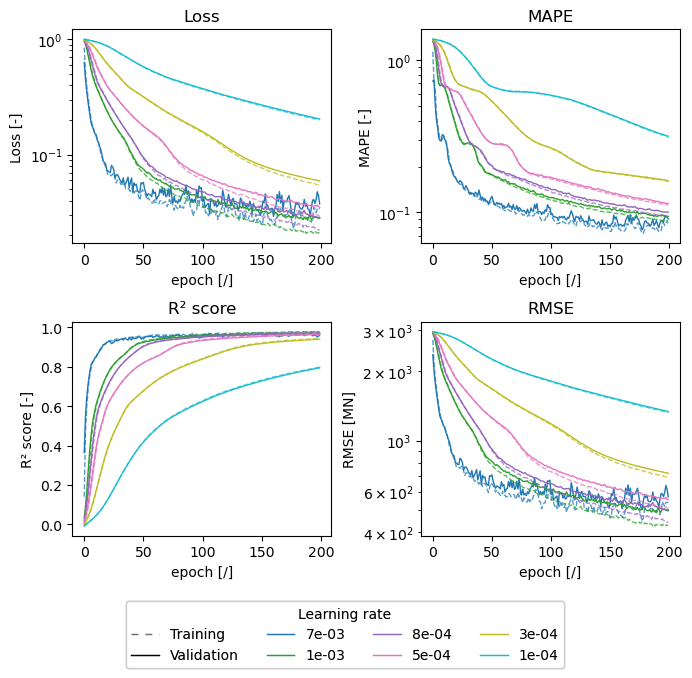

In [18]:
configs_by_val_mape = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = [x[1] for x in configs_by_val_mape][-6:]

labels = [f"{float(c):.0e}" for c in configs]

fig, axs = plot(results, configs, ['loss', 'mape', 'r2', 'rmse_MN'], ['Loss', 'MAPE', 'R² score', 'RMSE'],
                ['Loss [-]', 'MAPE [-]', 'R² score [-]', 'RMSE [MN]'],
                labels, logs=[True, True, False, True], figsize=(7, 6), legend_blank=False, legend_ncols=4,
                legend_title=r'Learning rate', )

for ax in axs[1:2]:
    ax.set_ylim([min(.099, ax.get_ylim()[0]), ax.get_ylim()[1]])

plt.savefig("figures/img/03-mlp_hybrid_learning_rate_tuning.pdf", transparent=True, bbox_inches='tight')
plt.show()
plt.close()

In [50]:
# Pareto front technique
best_mape = configs_by_val_mape[0][0]
candidates = [x[1] for x in filter(lambda x: x[0] <= best_mape * 1.02, configs_by_val_mape)]

filtered_results = {k: results[k] for k in candidates}

configs_by_val_rmse = sorted([(np.min(v['val_rmse_MN']), k) for k, v in filtered_results.items()])

best_candidate = configs_by_val_rmse[0][1]
best_learning_rate = float(best_candidate)

print(f"Best candidate is: {best_candidate} according to the pareto front.")

Best candidate is: 2.5e-03 according to the pareto front.


In [12]:
best_learning_rate = 5e-4
best_learning_rate = 1e-3

# Training final model

## Training

In [74]:
best_factors_copy = best_factors.copy()
best_factors['stiffness'] = 1e-3

In [13]:
best_factors = {'mse': 6.905724828654454, 'energy': 0.00105730071966418, 'stiffness': 0.7922598518631735,
                'equilibrium': 0.0010624793654702488}

In [14]:
%%capture
mlflow.set_experiment("training")

VAL_BATCH_SIZE = 8192
N_EPOCH = 2_000
log_step = -1

sizes = [2 ** i for i in range(7, 13)][::-1]
batch_size_values = [512 for _ in sizes]
dataset_path_values = [f"{train_dataset_dir}/{n}.hdf5" for n in sizes]

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for i, (dataset_path, TRAIN_BATCH_SIZE) in enumerate(zip(dataset_path_values, batch_size_values)):
        size = sizes[i]
        train_dataset = DummyTrussDataset(dataset_path)
        validation_dataset = _validation_ds
        future = executor.submit(trial_routine, None, train,
                                 {
                                     'input_dim': n_input_dims,
                                     'hidden_dims': best_hidden_dims,
                                     'output_dim': n_output_dims,
                                     'activation': best_activation,
                                     'activation_params': best_activation_params,
                                     'dropout': 0.0,
                                     'batch_norm': False,
                                     'layer_norm': False,
                                     'normalization_params': None,
                                     'output_activation': None,
                                     'output_activation_params': None,
                                 },
                                 train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                 N_EPOCH,
                                 torch.optim.Adam, LR, {'mse': nn.MSELoss,
                                                        'energy': EnergyLoss,
                                                        'stiffness': StiffnessToLoadLoss,
                                                        'equilibrium': NodeEquilibriumLoss},
                                 kfold, best_factors, log_step,
                                 {'loss': loss})
        futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

In [7]:
experiment = mlflow.get_experiment_by_name("training")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

sizes = set()
for size in runs_df['params.train_size'].unique():
    sizes.add(size)

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in sizes}
for size in sizes:
    run_ids = runs_df[
        (runs_df['params.loss'] == loss) &
        (runs_df['params.train_size'] == size)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[size][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

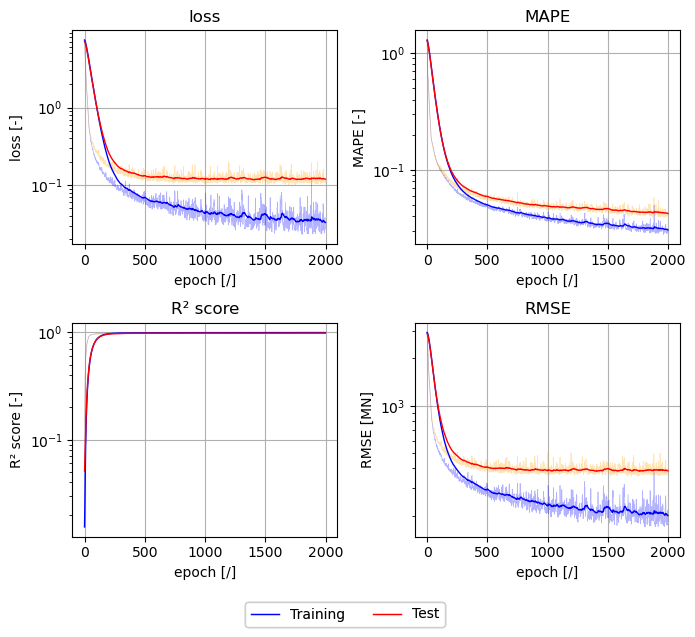

In [10]:
def moving_average(x, alpha):
    avg = [xi for xi in x]
    for i in range(1, len(x)):
        avg[i] = alpha * avg[i] + (1 - alpha) * avg[i - 1]
    return np.array(avg)


metrics = ['loss', 'mape', 'r2', 'rmse_MN']
figsize = (7, 6)
logs = [True, True, True, True, True, False, True]
legend_blank = False
legend_title = r'Training Dataset Size'
titles = ['loss', 'MAPE', 'R² score', 'RMSE']
axis_titles = [ 'loss [-]', 'MAPE [-]', 'R² score [-]', 'RMSE [MN]']
legend_ncols = 4

configs = ['4096']

labels = [f"{int(size)}" for size in configs]

cmap = mpl.colormaps['tab10']
c = cmap(np.linspace(0, 1, 2 * len(configs)))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)
axs = [ax for row in axs for ax in row]

for i, (title, y_axis_title, metric, log) in enumerate(zip(titles, axis_titles, metrics, logs)):
    ax = axs[i]
    # Plot the data but collect the handles for the legend
    config_handles = []
    for j, conf in enumerate(configs):
        # Store only the validation line handles for the legend
        l = len(results[conf][f'train_{metric}'])

        train_metric = results[conf][f'train_{metric}']
        test_metric = results[conf][f'val_{metric}']
        if title == 'Stiffness loss':
            train_metric = [1e12 * m for m in train_metric]
            test_metric = [1e12 * m for m in test_metric]
        ax.plot(np.arange(l), train_metric, ls='-', alpha=.3, lw=.5, c='b')[0]
        ax.plot(np.arange(l), test_metric, ls='-', alpha=.3, lw=.5, c='orange')[0]

        mean_train_metric = moving_average(train_metric, alpha=.025)
        mean_test_metric = moving_average(test_metric, alpha=.025)

        if i == 0:
            ax.plot(np.arange(l), mean_train_metric, ls='-', lw=1, c='b', label='Training')[0]
            ax.plot(np.arange(l), mean_test_metric, ls='-', lw=1, c='r', label='Test')[0]
        else:
            ax.plot(np.arange(l), mean_train_metric, ls='-', lw=1, c='b')[0]
            ax.plot(np.arange(l), mean_test_metric, ls='-', lw=1, c='r')[0]

    # Get the current position and size of the axis
    box = ax.get_position()
    # Reduce the width of the axis to make room for the legend
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Combine both sets of handles and labels
    # Create a single legend with both line styles and configurations
    plt.figlegend(loc='upper center', ncols=legend_ncols,
                  bbox_to_anchor=(.5, 0), fontsize=10)

    ax.set_title(title, fontsize=12)
    if log:
        ax.set_yscale('log')
    ax.set_ylabel(f"{y_axis_title}", fontsize=10)
    ax.set_xlabel("epoch [/]", fontsize=10)
    ax.grid()

fig.tight_layout(w_pad=4)

#for ax in axs[1:2]:
#    ax.set_ylim([min(.099, ax.get_ylim()[0]), ax.get_ylim()[1]])

plt.savefig("figures/img/03-hybrid_loss_test.pdf", transparent=True, bbox_inches='tight')
plt.show()
plt.close()

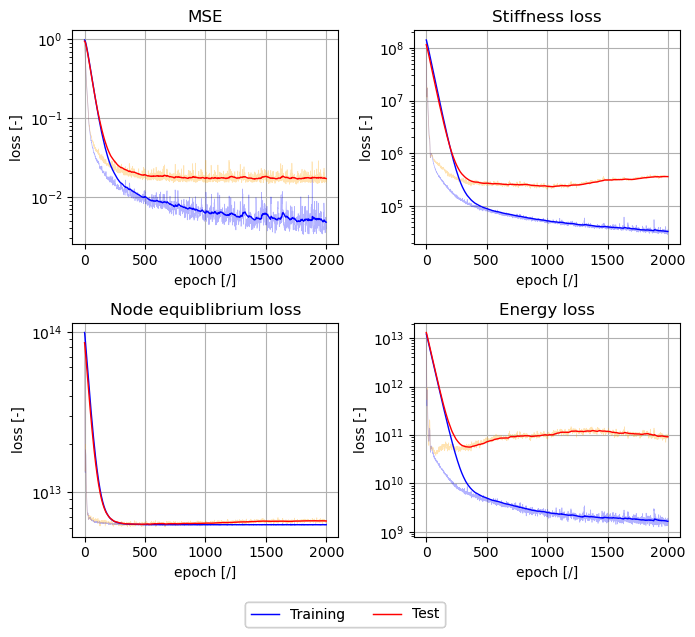

In [11]:
def moving_average(x, alpha):
    avg = [xi for xi in x]
    for i in range(1, len(x)):
        avg[i] = alpha * avg[i] + (1 - alpha) * avg[i - 1]
    return np.array(avg)


metrics = ['loss_mse', 'loss_stiffness', 'loss_equilibrium', 'loss_energy']
figsize = (7, 6)
logs = [True, True, True, True]
legend_blank = False
legend_title = r'Training Dataset Size'
titles = ['MSE', 'Stiffness loss', 'Node equiblibrium loss', 'Energy loss']
axis_titles = ['loss [-]', 'loss [-]', 'loss [-]', 'loss [-]']
legend_ncols = 4

configs = ['4096']

labels = [f"{int(size)}" for size in configs]

cmap = mpl.colormaps['tab10']
c = cmap(np.linspace(0, 1, 2 * len(configs)))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)
axs = [ax for row in axs for ax in row]

for i, (title, y_axis_title, metric, log) in enumerate(zip(titles, axis_titles, metrics, logs)):
    ax = axs[i]
    # Plot the data but collect the handles for the legend
    config_handles = []
    for j, conf in enumerate(configs):
        # Store only the validation line handles for the legend
        l = len(results[conf][f'train_{metric}'])

        train_metric = results[conf][f'train_{metric}']
        test_metric = results[conf][f'val_{metric}']
        if title == 'Stiffness loss':
            train_metric = [1e12 * m for m in train_metric]
            test_metric = [1e12 * m for m in test_metric]
        ax.plot(np.arange(l), train_metric, ls='-', alpha=.3, lw=.5, c='b')[0]
        ax.plot(np.arange(l), test_metric, ls='-', alpha=.3, lw=.5, c='orange')[0]

        mean_train_metric = moving_average(train_metric, alpha=.025)
        mean_test_metric = moving_average(test_metric, alpha=.025)

        if i == 0:
            ax.plot(np.arange(l), mean_train_metric, ls='-', lw=1, c='b', label='Training')[0]
            ax.plot(np.arange(l), mean_test_metric, ls='-', lw=1, c='r', label='Test')[0]
        else:
            ax.plot(np.arange(l), mean_train_metric, ls='-', lw=1, c='b')[0]
            ax.plot(np.arange(l), mean_test_metric, ls='-', lw=1, c='r')[0]

    # Get the current position and size of the axis
    box = ax.get_position()
    # Reduce the width of the axis to make room for the legend
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Combine both sets of handles and labels
    # Create a single legend with both line styles and configurations
    plt.figlegend(loc='upper center', ncols=legend_ncols,
                  bbox_to_anchor=(.5, 0), fontsize=10)

    ax.set_title(title, fontsize=12)
    if log:
        ax.set_yscale('log')
    ax.set_ylabel(f"{y_axis_title}", fontsize=10)
    ax.set_xlabel("epoch [/]", fontsize=10)
    ax.grid()

fig.tight_layout(w_pad=4)

#for ax in axs[1:2]:
#    ax.set_ylim([min(.099, ax.get_ylim()[0]), ax.get_ylim()[1]])

plt.savefig("figures/img/03-hybrid_loss_test_loss_decomposition.pdf", transparent=True, bbox_inches='tight')
plt.show()
plt.close()

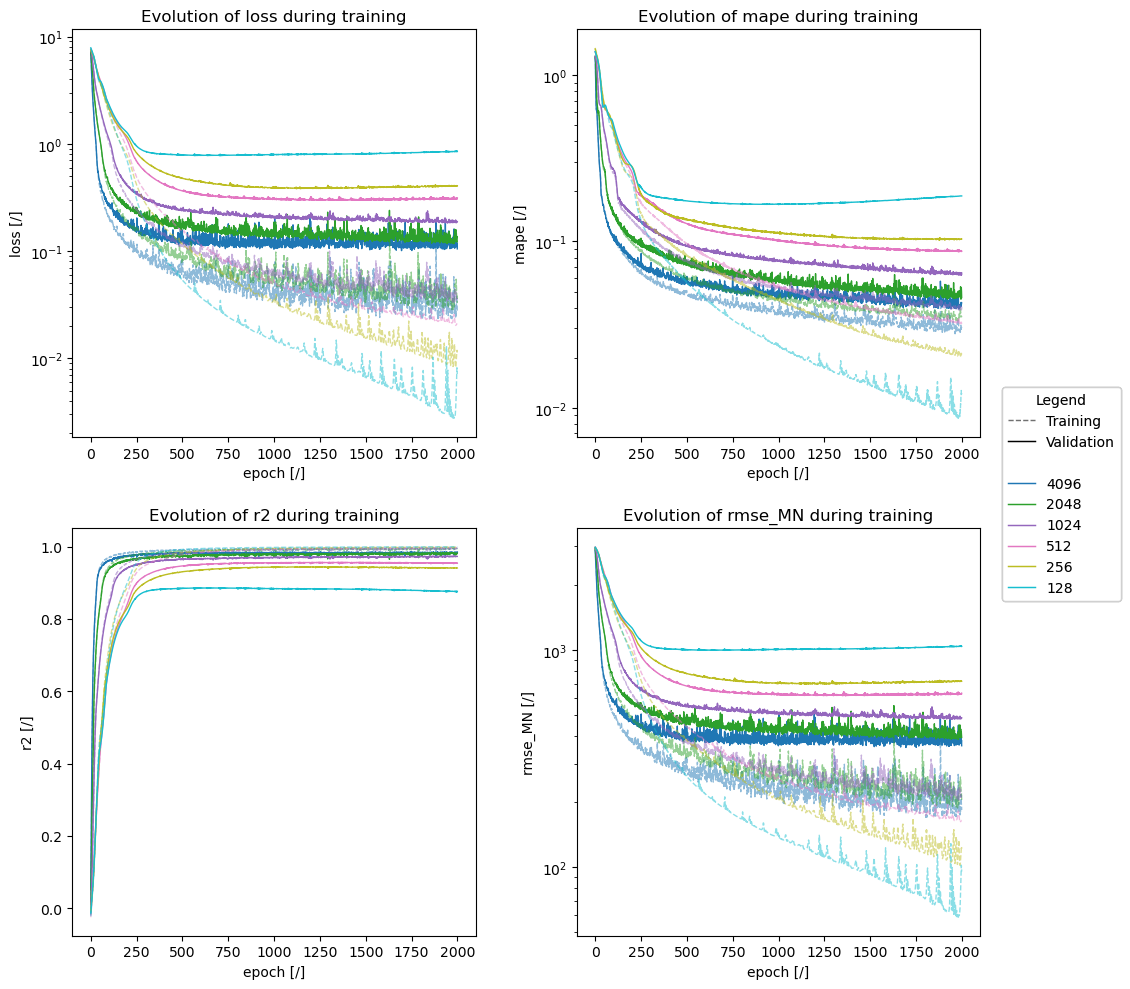

In [16]:
configs = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = [x[1] for x in configs]

labels = [f"{int(size)}" for size in configs]

plot(results, configs, ['loss', 'mape', 'r2', 'rmse_MN'], labels, logs=[True, True, False, True])

## Noise sensitivity

In [17]:
%%capture
experiment = mlflow.get_experiment_by_name("training")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
runs_df = runs_df[runs_df['params.loss'] == loss]

results = []

for f in np.linspace(0, .1, 11):
    validation_ds = DummyTrussDataset(
        f"{test_dataset_dir}/val_512.hdf5",
        f_noise_loads=lambda size: np.random.normal(1, f / 2, size),
        f_noise_displacement=lambda size: np.random.normal(1, f / 2, size),
        f_noise_strain=lambda size: np.random.normal(1, f / 2, size)
    )

    dl = DataLoader(validation_ds, batch_size=8192)

    for i in range(len(runs_df[['artifact_uri', 'params.train_size']])):
        artifact_uri = runs_df.iloc[i]['artifact_uri']
        size = runs_df.iloc[i]['params.train_size']

        uri = f"{artifact_uri}/input_scaler/"
        input_scaler = load_model(uri)

        uri = f"{artifact_uri}/target_scaler/"
        target_scaler = load_model(uri)

        uri = f"{artifact_uri}/mape_model/"
        model = load_model(uri)

        for batch in dl:
            metrics = validation(model, batch, input_scaler, target_scaler,
                                 {'mse': nn.MSELoss(),
                                  'energy': EnergyLoss(),
                                  'stiffness': StiffnessToLoadLoss(),
                                  'equilibrium': NodeEquilibriumLoss()},
                                 factor=best_factors,
                                 base_factor=compute_base_factor(model, dl, input_scaler, target_scaler,
                                                                 criterion={'mse': nn.MSELoss(),
                                                                            'energy': EnergyLoss(),
                                                                            'stiffness': StiffnessToLoadLoss(),
                                                                            'equilibrium': NodeEquilibriumLoss()}))
        results.append((size, f, metrics))

mlflow.set_experiment("noise_sensitivity")

df = pd.DataFrame([[results[i][0], results[i][1],
                    results[i][2]['r2'].item(),
                    results[i][2]['mape'].item(),
                    results[i][2]['rmse_MN'].item(),
                    results[i][2]['loss']]
                   for i in range(len(results))], columns=['train_size', 'noise', 'r2', 'mape', 'rmse_MN', 'loss'])
df.sort_values(by=['train_size', 'noise'], axis=0, ignore_index=True, inplace=True)

for size in df.train_size.unique():
    with mlflow.start_run():
        df_2 = df[df['train_size'] == size]
        # Model information logging
        mlflow.log_params({
            'train_size': size,
            'loss': loss,
            'test_set': 'single_ea'
        })
        for i in range(len(df_2)):
            mlflow.log_metrics(
                dict(df_2.iloc[i][1:]),
                step=i
            )

# Closing the server

In [13]:
server.terminate()

Server not running.
